<a href="https://colab.research.google.com/github/sumit-mandal/colab_google/blob/main/trafffic_signs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [101]:
!ls german-traffic-signs


signnames.csv  test.p  train.p	valid.p


In [102]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout,Flatten
from keras.layers.convolutional import Conv2D,MaxPooling2D
import pickle 
#“Pickling” is the process whereby a Python object hierarchy is 
#converted into a byte stream, and “unpickling” is the inverse operation, 
#whereby a byte stream (from a binary file or bytes-like object) is converted 
#back into an object hierarchy.
import pandas as pd
import random

In [103]:
np.random.seed(0)

In [104]:
with open('german-traffic-signs/train.p','rb') as f:
  train_data=pickle.load(f)
#with is used whenever you wish to excecute two operation as a pair and have a block of code invoke in between
#rb is used when we are only reading the file
with open('german-traffic-signs/valid.p','rb') as f:
  val_data=pickle.load(f)

with open('german-traffic-signs/test.p','rb') as f:
  test_data=pickle.load(f)

print(type(train_data))

X_train,y_train = train_data['features'],train_data['labels']
# feature corresponds to vilues of training images and pixel representation
# features value corresponds to an array of labels which pretty much label each training
#image as belonging to some class.
X_val,y_val = val_data['features'],val_data['labels']
X_test, y_test = test_data['features'],test_data['labels']



<class 'dict'>


In [105]:
print("Value of x train is",X_train.shape)
print("Value of x val is",X_val.shape)
print("Value of x test is",X_test.shape)

Value of x train is (34799, 32, 32, 3)
Value of x val is (4410, 32, 32, 3)
Value of x test is (12630, 32, 32, 3)


In [106]:
assert(X_train.shape[0] == y_train.shape[0]),'the number of images is not equal to the number of labels'
assert(X_val.shape[0] == y_val.shape[0]),'the number of images is not equal to the number of labels'
assert(X_test.shape[0] == y_test.shape[0]),'the number of images is not equal to the number of labels'

assert(X_train.shape[1:] == (32,32,3)),"The dimesion of the images are not 32x 32x 3"
#We must assert that the training image index 1 and beyond equals 32 by 32 by 3.
#So we assert X train shape at index 1 and beyond equals the tuple 32.
assert(X_val.shape[1:] == (32,32,3)),"The dimesion of the images are not 32x 32x 3"
assert(X_test.shape[1:] == (32,32,3)),"The dimesion of the images are not 32x 32x 3"

In [107]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
print(data)


    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

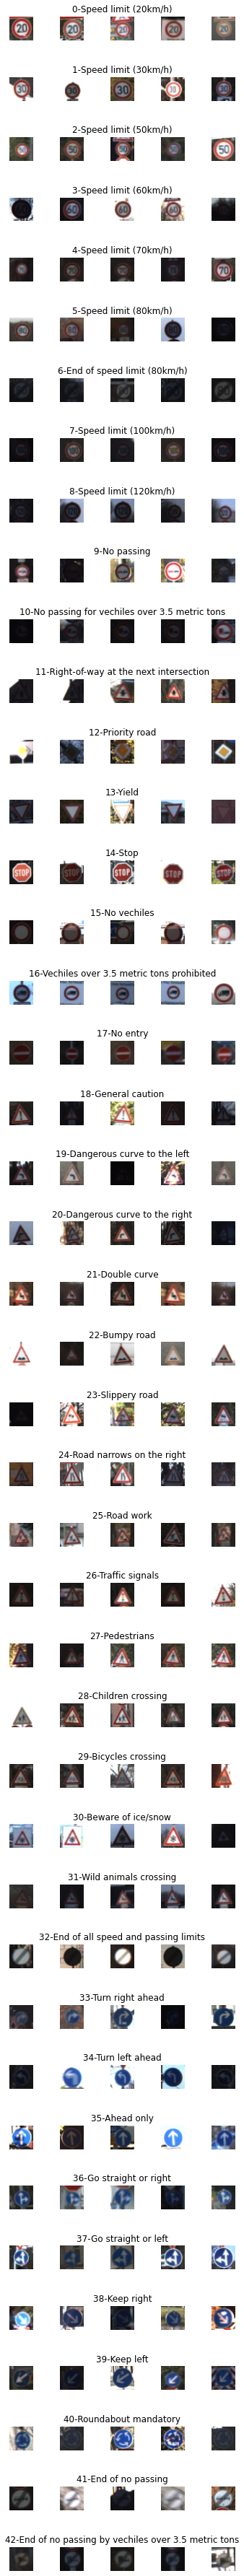

In [108]:
num_of_samples = []

cols = 5
num_classes = 43

fig,axs = plt.subplots(nrows = num_classes, ncols = cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
  for j,row in data.iterrows():
    #iterrows allows us to iterate over our entire a data frame rows as index and series
    #(index,Series)

    x_selected = X_train[y_train == j]
    #array filters out the images which don't belongs to the class. 
        #y_train == j will take all of our data stored in x_train and only keep the image that have the label of j

    axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) -1 )),: , :],cmap = plt.get_cmap('gray'))
    axs[j][i].axis('off')
    if i == 2:
      axs[j][i].set_title(str(j) + "-" + row["SignName"])
      num_of_samples.append(len(x_selected))

#with imshow(x_selected) we plot image which corresponds to rows and colms that is being iterated through
        #after that we will plot randomly selected image which corresponds to current iteration to the current class
        #for each class j being iterated through access a random image from first dimension and then display full 28x28 dimension
        #range is from 0 to last images i.e x_selected-1

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


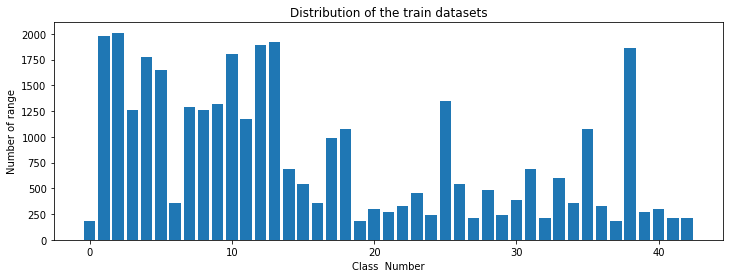

In [109]:
print(num_of_samples)
plt.figure(figsize=(12,4))
plt.bar(range(0,num_classes),num_of_samples)
plt.title("Distribution of the train datasets")
plt.xlabel("Class  Number")
plt.ylabel("Number of range")
plt.show()

(32, 32, 3)
36


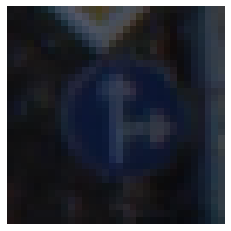

In [110]:
import cv2

plt.imshow(X_train[1000])
plt.axis("Off")
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


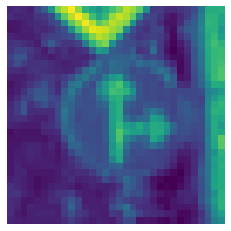

In [111]:
def grayscale(img):
  img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # Converts an image from one color space to another. parameter 1 - image we want to convert 
  #parameter in which color we want it to be converted
  return img

img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)


(32, 32)


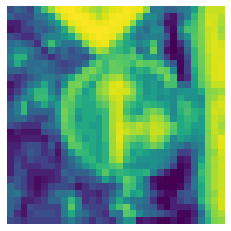

In [112]:
#histogram equalisation
#after histogram equalistion images have similR LIGHTING effect

def equalize(img):
  img = cv2.equalizeHist(img)
  return img

img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [113]:
#applying all the techiniques to all our images
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img

X_train = np.array(list(map(preprocessing,X_train)))

# What map will do is iterate through the entire array.
# And for every element of the array that it loops through it returns a new element based on the specified
# function that's allocated for each item in the array.
# Ultimately creating a new array with updated values into the function we're going to use to update each
# item in the array as the 'pre processing' function must just copy it and we are going to iterate through
# our entire "X train" datasets to ensure that all of our training images are processed correctly where
# each image from the array will go into the function as a parameter is preprocessed and then return as
# an updated value of the array.

#The map function will return the the images into the format of a list and therefore we can easily use
#the list function to store the return values.

X_val = np.array(list(map(preprocessing,X_val)))
X_test = np.array(list(map(preprocessing,X_test)))

(34799, 32, 32)


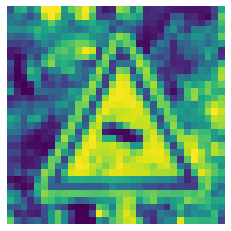

In [114]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis("off")
print(X_train.shape)

In [115]:
X_train = X_train.reshape(34799,32,32,1)
X_test = X_test.reshape(12630,32,32,1)
X_val = X_val.reshape(4410, 32, 32, 1)

In [116]:
#one hot encoding now
y_train = to_categorical(y_train , 43)
y_test = to_categorical(y_test , 43)
y_val = to_categorical(y_val , 43)

# to_categorical has number of rows equal to the length of the input vector and number of columns equal to the number of classes.



In [117]:
def modified_model():
  model = Sequential()
  #conolutional layer
  model.add(Conv2D(60,(5,5),input_shape=(32,32,1),activation='relu'))
   #instead of dense now we'll be using conv2d layer
  #no.of filters our layer will have here we have 60,then we have (5,5) tuples to define signs of filter
  #input_shape = (32,32,1). input will take image of 32X32 with depth of 1 with single channel
  #after this layer our 32x32 image is going to be reduced down to 60 feature map,each one 28x28 i.e.(28,28,60)
  #padding works to preserve the spatial funcationality of image

#adding new convolutional model
  model.add(Conv2D(60,(5,5),activation='relu'))

  #60 (filters) * 60 (depth) * 5(parameters)* 5(parameters) + (60)bias = 90060 parameters

  #now adding pooling layer
  model.add(MaxPooling2D(pool_size=(2,2)))
   #it takes size of pooling element as argument
   #after pooling our convulated image is going to reduce from (28,28,60) to smaller shape of 14x14x60



 #adding another conv layer
  model.add(Conv2D(30,(3,3),activation='relu'))

  #adding new convolutional  model
  model.add(Conv2D(30,(3,3),activation='relu'))

  #30 (filters) * 60 (depth) * 3(parameters)* 3(parameters) + (30)bias = 16230 parameters

  #adding another pooling
  model.add(MaxPooling2D(pool_size=(2,2)))
#it'll go into array as 6*6*30 = 1080

 # dropout  layer
  model.add(Dropout(0.5))




  #now flattening

  model.add(Flatten())

  #flattening will make it  1D array of 540

  #feeding into fully connected layer

  model.add(Dense(500,activation = 'relu'))
  
   #500 no. of nodes

  #dropout  layer
  model.add(Dropout(0.5))

  #The Dropout layer randomly sets input units to 0 with a frequency of rate 
  #at each step during training time, which helps prevent overfitting. 
  #Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over 
  #all inputs is unchanged.

  #output layer

  model.add(Dense(num_classes,activation='softmax'))

  #here number of node is equal to num_classes

  model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
  return model

In [118]:
model = modified_model()
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 4, 30)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 4, 4, 30)         

In [119]:
history = model.fit(X_train,y_train,epochs=10,validation_data =(X_val,y_val),batch_size = 400,verbose=1,shuffle=True )

Epoch 1/10
87/87 [==============================] - 2s 19ms/step - loss: 3.2646 - accuracy: 0.1326 - val_loss: 0.8589 - val_accuracy: 0.7612
Epoch 2/10
87/87 [==============================] - 2s 17ms/step - loss: 0.9365 - accuracy: 0.7121 - val_loss: 0.3284 - val_accuracy: 0.8973
Epoch 3/10
87/87 [==============================] - 1s 17ms/step - loss: 0.4728 - accuracy: 0.8542 - val_loss: 0.1941 - val_accuracy: 0.9417
Epoch 4/10
87/87 [==============================] - 2s 23ms/step - loss: 0.3134 - accuracy: 0.9041 - val_loss: 0.1766 - val_accuracy: 0.9422
Epoch 5/10
87/87 [==============================] - 1s 17ms/step - loss: 0.2414 - accuracy: 0.9231 - val_loss: 0.1129 - val_accuracy: 0.9646
Epoch 6/10
87/87 [==============================] - 1s 17ms/step - loss: 0.1931 - accuracy: 0.9397 - val_loss: 0.0898 - val_accuracy: 0.9748
Epoch 7/10
87/87 [==============================] - 1s 17ms/step - loss: 0.1538 - accuracy: 0.9520 - val_loss: 0.0922 - val_accuracy: 0.9732
Epoch 8/10
87

Text(0.5, 0, 'epoch')

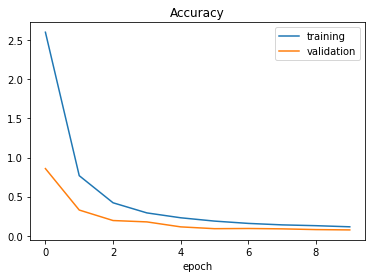

In [120]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

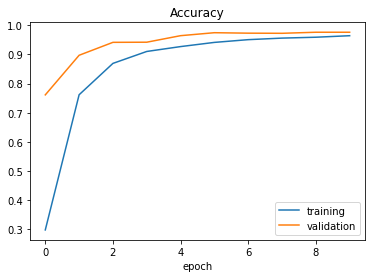

In [121]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [122]:
score = model.evaluate(X_test,y_test,verbose = 0)

print('Test Score:',score[0])
print("Test Accuracy:",score[1])

Test Score: 0.1455269157886505
Test Accuracy: 0.9556611180305481
